# Imbalanced Supervised Machine Learning

In [1]:
%matplotlib inline

# Ignore deprecated warning
import warnings
warnings.filterwarnings("ignore")

# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set font scale and style
plt.rcParams.update({'font.size': 15})

# Dimensionality reduction
from sklearn.decomposition import PCA

# Resampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# Machine learning models
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Grid search and model selection
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split

# Model performance metrics
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import  accuracy_score, auc,recall_score,precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score

# Pickle
import joblib

In [2]:
# Import custom class
%run -i '../src/helper/transfxn.py'
%run -i '../src/helper/ml.py'

# Load data

In [3]:
df = pd.read_csv('../data/clean_data.csv') # Load cleaned data

df = df.sample(frac =1).reset_index(drop = True) # shuffle

print('Data size',df.shape) # data size
df.head()

Data size (89990, 19)


,collision_id,location,x,y,longitude,latitude,environment,light,surface_condition,traffic_control,traffic_control_condition,class,impact_type,no_of_pedestrians,fid,c_year,c_month,c_day,c_hour
0,13-7364,CARTIER ST btwn MACLAREN ST & GILMOUR ST,368377.00000,5031199.5,-75.687660,45.417839,01 - Clear,05 - Dusk,01 - Dry,10 - No control,NaN,P.D. only,06 - SMV unattended vehicle,0.0,7598,2013,July,Wednesday,1
1,16-544,HAWTHORNE RD @ STEVENAGE DR,375136.65625,5027313.5,-75.601852,45.382233,01 - Clear,01 - Daylight,02 - Wet,01 - Traffic signal,01 - Functioning,Non-fatal injury,02 - Angle,0.0,544,2016,January,Thursday,17
2,14-2724,MELFORT ST @ WALKLEY RD,374446.21875,5028371.5,-75.610519,45.391819,03 - Snow,01 - Daylight,05 - Packed snow,01 - Traffic signal,01 - Functioning,P.D. only,02 - Angle,0.0,2806,2014,March,Saturday,16
3,16-13143,HIGHWAY 417 btwn HWY417 IC112 RAMP65 & HWY417 ...,374413.87500,5030844.5,-75.610580,45.414074,"07 - Fog, mist, smoke, dust",01 - Daylight,02 - Wet,10 - No control,NaN,P.D. only,07 - SMV other,0.0,13349,2016,March,Thursday,12
4,13-13095,COLONNADE RD @ MERIVALE RD,365363.68750,5022548.0,-75.727219,45.340267,01 - Clear,01 - Daylight,04 - Slush,01 - Traffic signal,01 - Functioning,P.D. only,02 - Angle,0.0,12973,2013,December,Sunday,18


# Class distribution

In [4]:
label_pct = df['class'].value_counts(normalize = True)*100
label_ct =  df['class'].value_counts()
pd.DataFrame({'labels': label_pct.index, 'count': label_ct.values, 'percentage': label_pct.values})

,labels,count,percentage
0,P.D. only,73454,81.624625
1,Non-fatal injury,16392,18.215357
2,Fatal injury,144,0.160018


In [5]:
# Create a binary class
map_dict = {'Non-fatal injury':0, 'P.D. only':0, 'Fatal injury':1}
df['class'].replace(map_dict, inplace=True)

# Prepare the Data for Machine Learning

In [6]:
# Feature matrix and class label
cols_to_drop = ['collision_id', 'location', 'longitude', 'latitude','class']
X, y = df.drop(cols_to_drop, axis = 1), df['class']

In [7]:
print('Data size:', X.shape, y.shape)

Data size: (89990, 14) (89990,)


# Create a test set
We now split the data set into $80\%$ training set and $20\%$ test set in a stratify fashion

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42, stratify = y)

In [9]:
print('Training set size:', X_train.shape, y_train.shape)
print('Test set size:', X_test.shape, y_test.shape)

Training set size: (71992, 14) (71992,)
Test set size: (17998, 14) (17998,)


In [10]:
print('Training set class distribution:\n', (y_train.value_counts()/X_train.shape[0])*100)
print('--' * 15)
print('Test set class distribution:\n', (y_test.value_counts()/X_test.shape[0])*100)

Training set class distribution:
 0    99.84026
1     0.15974
Name: class, dtype: float64
------------------------------
Test set class distribution:
 0    99.838871
1     0.161129
Name: class, dtype: float64


# Transformation pipeline

In [11]:
# Instantiate the class
transfxn = TransformationPipeline()

In [12]:
# Transform and scale data
X_train_scaled, X_test_scaled, feat_names = transfxn.preprocessing(X_train, X_test)

In [13]:
# Size of the data after pre-processing
print('Training set size after pre-processing:', X_train_scaled.shape)
print('Test set size after pre-processing:', X_test_scaled.shape)

Training set size after pre-processing: (71992, 83)
Test set size after pre-processing: (17998, 83)


In [14]:
# Convert the class labels to arrays
y_train, y_test = y_train.values,  y_test.values

# A. Model Selection by Cross-Validation

In this section, we train 4 different supervised ML models on the imbalanced dataset: 

1). Logistic Regression

2). Support Vector Machine classifier

3). Random Forest classifier

4). XGBoost classifier

The results show that the overall accuracy of the models is not a good  performance measure on the imbalanced datasets, as it is biased towards the majority (negative) class. Therefore, we shall select and optimize the model with the best area under the precision-recall (AUPR) curve. 

In [15]:
# Instantiate the class
model = SupervisedModels()

## A-1. Logistic Regression
Logistic regression predicted only one class - the majority class, although the accuracy and AUROC are very high

In [20]:
log_clf = LogisticRegression()   
model.eval_metrics_cv(log_clf, X_train_scaled, y_train, cv_fold = 5, scoring = 'accuracy', model_nm = "Logistic Regression")

5-Fold cross-validation results for Logistic Regression
------------------------------------------------------------
Accuracy (std): 0.998403 (0.000000)
AUROC: 0.827321
AUPRC: 0.008324
Predicted classes: [0]
Confusion matrix:
 [[71877     0]
 [  115     0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     71877
           1       0.00      0.00      0.00       115

    accuracy                           1.00     71992
   macro avg       0.50      0.50      0.50     71992
weighted avg       1.00      1.00      1.00     71992

------------------------------------------------------------


## A-2. Support Vector Machine

In [21]:
svm_clf = SVC(probability = True, kernel = 'rbf')   
model.eval_metrics_cv(svm_clf, X_train_scaled, y_train, cv_fold = 5, scoring = 'accuracy',      model_nm = "SVM Classifier")

5-Fold cross-validation results for SVM Classifier
------------------------------------------------------------
Accuracy (std): 0.998403 (0.000000)
AUROC: 0.606803
AUPRC: 0.003826
Predicted classes: [0]
Confusion matrix:
 [[71877     0]
 [  115     0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     71877
           1       0.00      0.00      0.00       115

    accuracy                           1.00     71992
   macro avg       0.50      0.50      0.50     71992
weighted avg       1.00      1.00      1.00     71992

------------------------------------------------------------


In [ ]:
# model.plot_auc_ap_svm(X_train_scaled, y_train, cv_fold = 5)

## A-3. Random Forest

In [22]:
rf_clf = RandomForestClassifier(random_state = 42)                         
model.eval_metrics_cv(rf_clf, X_train_scaled, y_train, cv_fold = 5, 
                        scoring = 'accuracy', model_nm = "Random Forest Classifier")

5-Fold cross-validation results for Random Forest Classifier
------------------------------------------------------------
Accuracy (std): 0.998403 (0.000000)
AUROC: 0.645909
AUPRC: 0.005961
Predicted classes: [0]
Confusion matrix:
 [[71877     0]
 [  115     0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     71877
           1       0.00      0.00      0.00       115

    accuracy                           1.00     71992
   macro avg       0.50      0.50      0.50     71992
weighted avg       1.00      1.00      1.00     71992

------------------------------------------------------------


Text(0.5, 1.0, 'Top 20 Feature Importances for Random Forest Classifier')

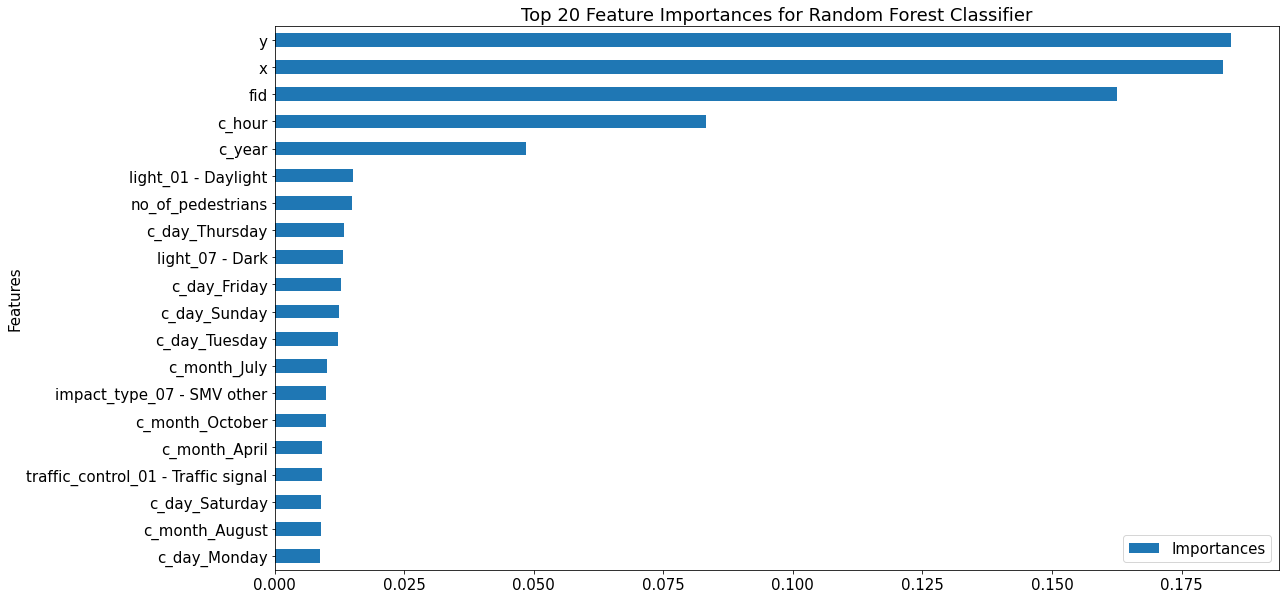

In [23]:
# Compute feature importances
importances_df = pd.DataFrame({'Features': feat_names, 
                                    'Importances': rf_clf.feature_importances_})

# Bar plot
importances_df.sort_values('Importances', ascending = True, inplace = True)
importances_df.set_index('Features', inplace = True)
importances_df.tail(20).plot(kind='barh', figsize = (18,10))
plt.title('Top 20 Feature Importances for Random Forest Classifier')

## A-4. XGBoost

In [24]:
param_dist = {'objective':'binary:logistic', 'eval_metric':'logloss', 'random_state':42}
xgb_clf = XGBClassifier(**param_dist) 
model.eval_metrics_cv(xgb_clf, X_train_scaled, y_train, cv_fold = 5,
                        scoring = 'accuracy', model_nm = "XGBoost Classifier")

5-Fold cross-validation results for XGBoost Classifier
------------------------------------------------------------
Accuracy (std): 0.998361 (0.000056)
AUROC: 0.745151
AUPRC: 0.004870
Predicted classes: [0 1]
Confusion matrix:
 [[71874     3]
 [  115     0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     71877
           1       0.00      0.00      0.00       115

    accuracy                           1.00     71992
   macro avg       0.50      0.50      0.50     71992
weighted avg       1.00      1.00      1.00     71992

------------------------------------------------------------


Text(0.5, 1.0, 'Top 20 Feature Importances for XGBoost Classifier')

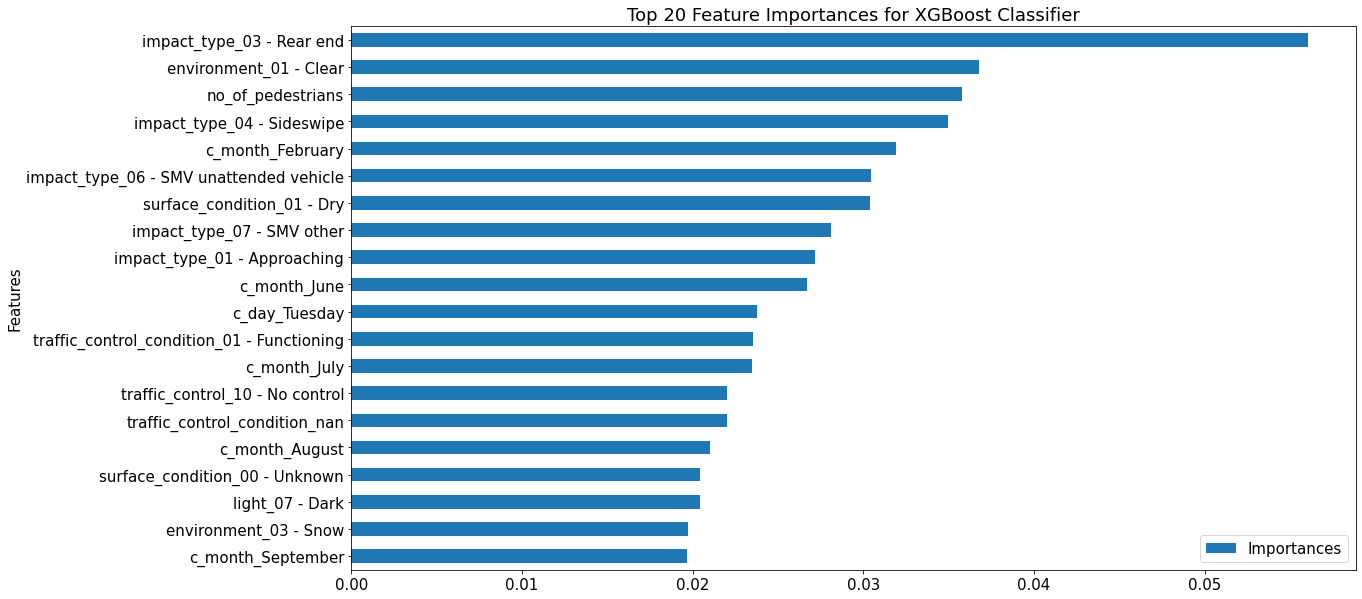

In [25]:
# Compute feature importances
importances_df = pd.DataFrame({'Features': feat_names,
                                 'Importances': xgb_clf.feature_importances_})
# Bar plot
importances_df.sort_values('Importances', ascending = True, inplace = True)
importances_df.set_index('Features', inplace = True)
importances_df.tail(20).plot(kind='barh', figsize = (18,10))
plt.title('Top 20 Feature Importances for XGBoost Classifier')

# B. Hyperparameter tuning - XGB
Based on the results above, we select XGBoost and tune the Hyperparameters

In [28]:
# Class ratio of the negative class to the positive class
neg = y_train == 0
pos = y_train == 1
class_ratio = np.sum(neg)/np.sum(pos)

# Range of hyperparameters
params = {'subsample':[i/10 for i in range(5,9)],'colsample_bytree': [i/10 for i in range(5,9)]}

# Randomized search
param_dist = {'objective':'binary:logistic', 'eval_metric':'logloss', 'n_estimators':2000,
              'scale_pos_weight':class_ratio, 'learning_rate':0.1, 
              'min_child_weight':5, 'max_depth':9,'random_state':42}
xgb_clf = XGBClassifier(**param_dist)

rsearch_xgb = RandomizedSearchCV(estimator = xgb_clf, param_distributions = params, 
                                  scoring = 'roc_auc', cv = 5, n_jobs = -1, n_iter = 200, 
                                  random_state = 42, verbose = 1)   
# Fit the  training set                                                            
rsearch_xgb.fit(X_train_scaled, y_train)

# Pickle trained model
joblib.dump(rsearch_xgb.best_estimator_, '../src/model/xgb_clf.pkl')

# Print results
print('Randomized search best AUC score:', rsearch_xgb.best_score_) 
print('Randomized search best hyperparameters:', rsearch_xgb.best_params_) 

Fitting 5 folds for each of 16 candidates, totalling 80 fits


# C. Resampling Methods
In this section, we will employ two resampling techniques on the training set to balance the classes. However, the final prediction will be made on the imbalanced test set. The idea of resampling is to trick the classifier using a balanced dataset.  

## C-1. SMOTE  combined with Random Forest Classifier
In Synthetic Minority Over Sampling Technique (SMOTE), we generate synthetic oberservations to match the minority clas.
SMOTE oversampled the minority class in the training set, so we now have equal class distribution. 

In [20]:
# Over sample the minority class
sm = SMOTE(random_state = 42)
X_train_scaled_ovsm, y_train_ovsm = sm.fit_resample(X_train_scaled, y_train)

In [21]:
print('SMOTE training data size:', X_train_scaled_ovsm.shape, y_train_ovsm.shape)

SMOTE training data size: (143754, 83) (143754,)


In [22]:
print('Imbalanced training set class distribution:', np.bincount(y_train))
print('SMOTE resampled training set class distribution:', np.bincount(y_train_ovsm))

Imbalanced training set class distribution: [71877   115]
SMOTE resampled training set class distribution: [71877 71877]


In [ ]:
# XGBoost cross-validation on the SMOTE dataset
param_dist = {'objective':'binary:logistic', 'eval_metric':'logloss', 'learning_rate':0.1,
            'random_state':42}
xgb_ovsm  = XGBClassifier(**param_dist)
model.eval_metrics_cv(rf_ovsm, X_train_scaled_ovsm, y_train_ovsm, cv_fold = 5, scoring = 'accuracy', model_nm = "SMOTE with XGBoost Classifier")

# D. Prediction on the Imbalanced Test Set 
In this section, we make our final prediction on the imbalanced dataset after training the model using the resampling techniques.

## D-1. Normal Imbalanced Dataset

In [ ]:
xgb_clf = joblib.load('../src/model/xgb_clf.pkl') # Load trained model
model.test_pred(rf_clf, X_train_scaled, y_train, X_test_scaled, y_test, model_nm = "XBoost Classifier")

## D-2. SMOTE Dataset

In [ ]:
model.test_pred(xgb_ovsm, X_train_scaled_ovsm, y_train_ovsm, X_test_scaled, y_test, model_nm = "SMOTE with XGBoost Classifier")

# E.  ROC and PR Curves


In [ ]:
plt.figure(figsize = (20,15))

# Normal imbalanced distribution
model.plot_roc_pr_curves(xgb_clf, X_train_scaled, y_train, X_test_scaled, y_test, cv_fold = 5,
                       color= 'b', label = 'Normal (AUC= %0.2f)')
                     
# SMOTE distribution
model.plot_roc_pr_curves(xgb_ovsm, X_train_scaled_ovsm, y_train_ovsm, X_test_scaled, y_test, cv_fold = 5, color= 'r', label = 'SMOTE (AUC= %0.2f)') 

# F. AUC-ROC and AUC-PR for Cross-Validation vs. Test Sets

In [ ]:
plt.figure(figsize = (20,8))

# Normal imbalanced distribution
model.plot_aucroc_aucpr(rf_clf, X_train_scaled, y_train, X_test_scaled, y_test, cv_fold = 5,
                       marker = 'o', color= 'b', label = 'Normal')
                     
# SMOTE distribution
model.plot_aucroc_aucpr(rf_ovsm, X_train_scaled_ovsm, y_train_ovsm, X_test_scaled, y_test, cv_fold = 5, marker = 'd', color= 'r', label = 'SMOTE') 